### Training MLP-models

Linn Alexandra Emhjellen, 2021. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix

from sklearn.metrics import recall_score,roc_curve,auc
from pandas.plotting import scatter_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import seaborn as sns

### Loading calibration set

In [3]:
train_X = pd.read_excel('ML_training_features.xlsx')
train_y = pd.read_excel('ML_training_target.xlsx')

### Loading validation set

In [4]:
validation_X = pd.read_excel('ML_validation_features.xlsx')
validation_y = pd.read_excel('ML_validation_target.xlsx')

In [5]:
validation_y = validation_y['ReleaseArea']
train_y = train_y['ReleaseArea']

#### The optimized hyperparameters from RandomSearch with cross-validation

In [6]:
best_params_MLP = pd.read_excel('MLP_best_params_RandomSearch.xlsx')
best_params_MLP = best_params_MLP.drop(columns = 'Unnamed: 0')
best_param_grid = best_params_MLP.to_dict(orient = 'records')

#### Defining feature combinations

In [7]:
# feature combinations
p1 = ['Slope']

p2 = ['Slope','Elevation']

p3 = ['Slope','North','East','North East','North West','South','South East','South West','West']

p4 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI','Distance_to_roads']

p5 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads']

p6 = ['Slope','Elevation','Plan_curv','Profile_curv','TRI']

p7 = ['Elevation','North','East','North East','North West','South','South East','South West','West','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads']

p8 = ['Slope','Elevation','North','East','North East','North West','South','South East','South West','West','Plan_curv','Profile_curv','TRI','Flow_dir','Flow_acc','Distance_to_roads',
      'Granite','Granodiorite','Tonalite','Trondhjemite','Syenite','Monzonite','Monzodiorite','Quartz diorite','Diorite','Gabbro','Norite','Peridotite','Pyroksenite','Charnockite','Mangerite','Anorthosite','Mafic dyke (Diabase, Dolerite)','Pegmatite/aplite','Felsic volcanic rock','Rhyolite','Dacite','Intermediate volcanic rock','Andesite','Mafic volcanic rock','Basalt',
                  'Pyroclastic rock','Volcanic breccia','Siltstone','Sandstone','Greywacke','Arkose','Konglomerate','Sedimentary breccia','Limestone','Tuffite','Shale','Phyllite','Mica schist','Garnet mica schist','Calcareous phyllite','Calcareous mica schist','Amphibole schist','Graphitic schist','Calcite marble',
                 'Metasandstone','Metagreywacke','Meta-arkose','Quartzite','Quartz schist','Mica gneiss','Calc-silicate rock','Amphibole gneiss','Granitic gneiss','Granodioritic gneiss','Tonalitic gneiss','Quartz dioritic gneiss','Monzonitic gneiss','Dioritic gneis','Orthopyroxene gneiss','Migmatite','Augengneiss',
                    'Banded gneiss','Greenschist','Greenstone','Amphibolite','Metagabbro','Eclogite','Serpentinite','Mylonite/Phyllonite','Cataclasite']

feature_combinations = [p1,p2,p3,p4,p5,p6,p7,p8]

### Training of models

In [8]:
clf_mlp_models = []
pred_release_training_MLP = []
pred_release_testing_MLP = []
pred_release_prob_MLP = []

confusion_matrixes_training = []
confusion_matrixes_test = []
#feature_importances = []

f1_scores = []
ROC_curves = []
CV_scores = []
R2_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []



n = 0
for i in feature_combinations:
    
    X_train = train_X[i]
    X_test = validation_X[i]

    AUTO_SCALING = True
    if AUTO_SCALING:
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_training = scaler.transform(X_train)
        X_testing = scaler.transform(X_test)
       
    #nnetwork = MLPClassifier(max_iter=1000)    
   
    clf_mlp = MLPClassifier(solver = best_param_grid[n]["solver"], hidden_layer_sizes = best_param_grid[n]["hidden_layer_sizes"], alpha = best_param_grid[n]["alpha"], max_iter=200,verbose=3)
    clf_mlp.fit(X_training, train_y)
    clf_mlp_models.append(clf_mlp)
    
    pred_release_at_training_MLP = clf_mlp.predict(X_training)
    pred_release_training_MLP.append(pred_release_at_training_MLP)
    
    pred_prob_MLP = clf_mlp.predict_proba(X_testing)
    pred_release_prob_MLP.append(pred_prob_MLP)
    
    pred_release_at_validation_MLP = clf_mlp.predict(X_testing)
    pred_release_testing_MLP.append(pred_release_at_validation_MLP)
    
    c_m = confusion_matrix(train_y,pred_release_at_training_MLP)
    confusion_matrixes_training.append(c_m)
    
    c_m_v = confusion_matrix(validation_y,pred_release_at_validation_MLP)
    confusion_matrixes_test.append(c_m_v)
    
    f1 = f1_score(validation_y, pred_release_at_validation_MLP, average='macro')
    f1_scores.append(f1)
    
    CV = cross_val_score(estimator= clf_mlp, X=X_training, y=train_y)
    CV_scores.append(CV)
    
    CLF_ROC = plot_roc_curve(clf_mlp, X_testing, validation_y, color = 'r')
    ROC_curves.append(CLF_ROC)
    plt.close()
    
    r2 = r2_score(validation_y, pred_release_at_validation_MLP)
    R2_scores.append(r2)
    
    acc = accuracy_score(validation_y, pred_release_at_validation_MLP)
    accuracy_scores.append(acc)
    
    precision = precision_score(validation_y, pred_release_at_validation_MLP)
    precision_scores.append(precision)
    
    recall = recall_score(validation_y, pred_release_at_validation_MLP)
    recall_scores.append(recall)
    
    roc_auc = roc_auc_score(validation_y, pred_release_at_validation_MLP)
    roc_auc_scores.append(roc_auc)
    
    n += 1

Iteration 1, loss = 0.49329313
Iteration 2, loss = 0.25705141
Iteration 3, loss = 0.18584060
Iteration 4, loss = 0.16627930
Iteration 5, loss = 0.16033727
Iteration 6, loss = 0.15839359
Iteration 7, loss = 0.15758800
Iteration 8, loss = 0.15718740
Iteration 9, loss = 0.15686088
Iteration 10, loss = 0.15666376
Iteration 11, loss = 0.15652130
Iteration 12, loss = 0.15639366
Iteration 13, loss = 0.15629016
Iteration 14, loss = 0.15629755
Iteration 15, loss = 0.15615804
Iteration 16, loss = 0.15619507
Iteration 17, loss = 0.15616823
Iteration 18, loss = 0.15612967
Iteration 19, loss = 0.15618076
Iteration 20, loss = 0.15615905
Iteration 21, loss = 0.15602008
Iteration 22, loss = 0.15617861
Iteration 23, loss = 0.15607845
Iteration 24, loss = 0.15613335
Iteration 25, loss = 0.15618914
Iteration 26, loss = 0.15611393
Iteration 27, loss = 0.15606942
Iteration 28, loss = 0.15602103
Iteration 29, loss = 0.15609924
Iteration 30, loss = 0.15611314
Iteration 31, loss = 0.15608958
Iteration 32, los

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

Iteration 1, loss = 0.48892907
Iteration 2, loss = 0.25166553
Iteration 3, loss = 0.20244590
Iteration 4, loss = 0.18799445
Iteration 5, loss = 0.18136986
Iteration 6, loss = 0.17754311
Iteration 7, loss = 0.17484031
Iteration 8, loss = 0.17321192
Iteration 9, loss = 0.17226888
Iteration 10, loss = 0.17119937
Iteration 11, loss = 0.17055765
Iteration 12, loss = 0.17006394
Iteration 13, loss = 0.16953533
Iteration 14, loss = 0.16930679
Iteration 15, loss = 0.16900752
Iteration 16, loss = 0.16901378
Iteration 17, loss = 0.16877523
Iteration 18, loss = 0.16883850
Iteration 19, loss = 0.16863304
Iteration 20, loss = 0.16852365
Iteration 21, loss = 0.16863493
Iteration 22, loss = 0.16836198
Iteration 23, loss = 0.16844024
Iteration 24, loss = 0.16832229
Iteration 25, loss = 0.16826388
Iteration 26, loss = 0.16828224
Iteration 27, loss = 0.16816954
Iteration 28, loss = 0.16823874
Iteration 29, loss = 0.16823795
Iteration 30, loss = 0.16802659
Iteration 31, loss = 0.16816288
Iteration 32, los

Iteration 19, loss = 0.17211451
Iteration 20, loss = 0.17177975
Iteration 21, loss = 0.17190084
Iteration 22, loss = 0.17168785
Iteration 23, loss = 0.17158649
Iteration 24, loss = 0.17164491
Iteration 25, loss = 0.17143937
Iteration 26, loss = 0.17148690
Iteration 27, loss = 0.17157937
Iteration 28, loss = 0.17126049
Iteration 29, loss = 0.17128867
Iteration 30, loss = 0.17128537
Iteration 31, loss = 0.17120853
Iteration 32, loss = 0.17125408
Iteration 33, loss = 0.17126612
Iteration 34, loss = 0.17104033
Iteration 35, loss = 0.17128975
Iteration 36, loss = 0.17105420
Iteration 37, loss = 0.17100883
Iteration 38, loss = 0.17103718
Iteration 39, loss = 0.17107349
Iteration 40, loss = 0.17110511
Iteration 41, loss = 0.17100747
Iteration 42, loss = 0.17124864
Iteration 43, loss = 0.17091055
Iteration 44, loss = 0.17116297
Iteration 45, loss = 0.17099877
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.40897591
Iteration 2, lo

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.43356551
Iteration 2, loss = 0.23849093
Iteration 3, loss = 0.17866213
Iteration 4, loss = 0.15609459
Iteration 5, loss = 0.14613023
Iteration 6, loss = 0.14082568
Iteration 7, loss = 0.13746849
Iteration 8, loss = 0.13516803
Iteration 9, loss = 0.13347502
Iteration 10, loss = 0.13197186
Iteration 11, loss = 0.13087770
Iteration 12, loss = 0.12977505
Iteration 13, loss = 0.12873746
Iteration 14, loss = 0.12810431
Iteration 15, loss = 0.12716588
Iteration 16, loss = 0.12635059
Iteration 17, loss = 0.12572446
Iteration 18, loss = 0.12501772
Iteration 19, loss = 0.12452491
Iteration 20, loss = 0.12384954
Iteration 21, loss = 0.12320323
Iteration 22, loss = 0.12283299
Iteration 23, loss = 0.12246799
Iteration 24, loss = 0.12175186
Iteration 25, loss = 0.12144506
Iteration 26, loss = 0.12079248
Iteration 27, loss = 0.12056707
Iteration 28, loss = 0.11995714
Iteration 29, loss = 0.11969717
Iteration 30, loss = 0.11928999
Iteration 31, loss = 0.11882624
Iteration 32, los

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.23961161
Iteration 3, loss = 0.17553127
Iteration 4, loss = 0.15373956
Iteration 5, loss = 0.14481658
Iteration 6, loss = 0.13981566
Iteration 7, loss = 0.13697285
Iteration 8, loss = 0.13506786
Iteration 9, loss = 0.13341086
Iteration 10, loss = 0.13230645
Iteration 11, loss = 0.13127388
Iteration 12, loss = 0.13005548
Iteration 13, loss = 0.12942309
Iteration 14, loss = 0.12867178
Iteration 15, loss = 0.12805260
Iteration 16, loss = 0.12706528
Iteration 17, loss = 0.12653286
Iteration 18, loss = 0.12573598
Iteration 19, loss = 0.12525984
Iteration 20, loss = 0.12436652
Iteration 21, loss = 0.12384305
Iteration 22, loss = 0.12326031
Iteration 23, loss = 0.12255092
Iteration 24, loss = 0.12203784
Iteration 25, loss = 0.12167608
Iteration 26, loss = 0.12114012
Iteration 27, loss = 0.12068833
Iteration 28, loss = 0.12007659
Iteration 29, loss = 0.11968818
Iteration 30, loss = 0.11933996
Iteration 31, loss = 0.11908276
Iteration 32, loss = 0.11860323
Iteration 33, lo

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.23996454
Iteration 3, loss = 0.17680339
Iteration 4, loss = 0.15445503
Iteration 5, loss = 0.14503697
Iteration 6, loss = 0.14007051
Iteration 7, loss = 0.13723031
Iteration 8, loss = 0.13536892
Iteration 9, loss = 0.13412958
Iteration 10, loss = 0.13311274
Iteration 11, loss = 0.13231649
Iteration 12, loss = 0.13140123
Iteration 13, loss = 0.13076611
Iteration 14, loss = 0.12998822
Iteration 15, loss = 0.12917700
Iteration 16, loss = 0.12884207
Iteration 17, loss = 0.12835663
Iteration 18, loss = 0.12762448
Iteration 19, loss = 0.12703817
Iteration 20, loss = 0.12653163
Iteration 21, loss = 0.12611982
Iteration 22, loss = 0.12566805
Iteration 23, loss = 0.12496474
Iteration 24, loss = 0.12453627
Iteration 25, loss = 0.12408784
Iteration 26, loss = 0.12378943
Iteration 27, loss = 0.12320687
Iteration 28, loss = 0.12279574
Iteration 29, loss = 0.12240849
Iteration 30, loss = 0.12187302
Iteration 31, loss = 0.12163900
Iteration 32, loss = 0.12111030
Iteration 33, lo

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.21965303
Iteration 3, loss = 0.16567842
Iteration 4, loss = 0.14848574
Iteration 5, loss = 0.14138165
Iteration 6, loss = 0.13729175
Iteration 7, loss = 0.13508107
Iteration 8, loss = 0.13344559
Iteration 9, loss = 0.13208670
Iteration 10, loss = 0.13125669
Iteration 11, loss = 0.13045483
Iteration 12, loss = 0.12969200
Iteration 13, loss = 0.12873765
Iteration 14, loss = 0.12833032
Iteration 15, loss = 0.12757306
Iteration 16, loss = 0.12698184
Iteration 17, loss = 0.12635309
Iteration 18, loss = 0.12592885
Iteration 19, loss = 0.12539991
Iteration 20, loss = 0.12486567
Iteration 21, loss = 0.12436105
Iteration 22, loss = 0.12391219
Iteration 23, loss = 0.12369810
Iteration 24, loss = 0.12305622
Iteration 25, loss = 0.12256565
Iteration 26, loss = 0.12225405
Iteration 27, loss = 0.12174719
Iteration 28, loss = 0.12141148
Iteration 29, loss = 0.12103588
Iteration 30, loss = 0.12070892
Iteration 31, loss = 0.12035546
Iteration 32, loss = 0.12019287
Iteration 33, lo

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 3, loss = 0.17808264
Iteration 4, loss = 0.15643869
Iteration 5, loss = 0.14727684
Iteration 6, loss = 0.14235755
Iteration 7, loss = 0.13987850
Iteration 8, loss = 0.13789349
Iteration 9, loss = 0.13685355
Iteration 10, loss = 0.13594695
Iteration 11, loss = 0.13494085
Iteration 12, loss = 0.13432384
Iteration 13, loss = 0.13356547
Iteration 14, loss = 0.13294589
Iteration 15, loss = 0.13236772
Iteration 16, loss = 0.13155841
Iteration 17, loss = 0.13125595
Iteration 18, loss = 0.13068431
Iteration 19, loss = 0.13011792
Iteration 20, loss = 0.12942175
Iteration 21, loss = 0.12872247
Iteration 22, loss = 0.12804403
Iteration 23, loss = 0.12740422
Iteration 24, loss = 0.12693347
Iteration 25, loss = 0.12624293
Iteration 26, loss = 0.12586076
Iteration 27, loss = 0.12559844
Iteration 28, loss = 0.12492624
Iteration 29, loss = 0.12405949
Iteration 30, loss = 0.12341299
Iteration 31, loss = 0.12320420
Iteration 32, loss = 0.12245905
Iteration 33, loss = 0.12227073
Iteration 34, 

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.41668715
Iteration 2, loss = 0.21422159
Iteration 3, loss = 0.18225380
Iteration 4, loss = 0.17422062
Iteration 5, loss = 0.17071201
Iteration 6, loss = 0.16882231
Iteration 7, loss = 0.16738579
Iteration 8, loss = 0.16643921
Iteration 9, loss = 0.16572551
Iteration 10, loss = 0.16501167
Iteration 11, loss = 0.16457999
Iteration 12, loss = 0.16411704
Iteration 13, loss = 0.16399043
Iteration 14, loss = 0.16353731
Iteration 15, loss = 0.16353906
Iteration 16, loss = 0.16319336
Iteration 17, loss = 0.16311658
Iteration 18, loss = 0.16300894
Iteration 19, loss = 0.16282886
Iteration 20, loss = 0.16273838
Iteration 21, loss = 0.16280690
Iteration 22, loss = 0.16257304
Iteration 23, loss = 0.16256361
Iteration 24, loss = 0.16261487
Iteration 25, loss = 0.16254518
Iteration 26, loss = 0.16251474
Iteration 27, loss = 0.16237040
Iteration 28, loss = 0.16243855
Iteration 29, loss = 0.16246395
Iteration 30, loss = 0.16250733
Iteration 31, loss = 0.16235950
Iteration 32, los

Iteration 31, loss = 0.16510676
Iteration 32, loss = 0.16506776
Iteration 33, loss = 0.16511343
Iteration 34, loss = 0.16521618
Iteration 35, loss = 0.16512188
Iteration 36, loss = 0.16499861
Iteration 37, loss = 0.16492762
Iteration 38, loss = 0.16520707
Iteration 39, loss = 0.16493184
Iteration 40, loss = 0.16503004
Iteration 41, loss = 0.16510923
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.52093640
Iteration 2, loss = 0.39700210
Iteration 3, loss = 0.35313258
Iteration 4, loss = 0.32855498
Iteration 5, loss = 0.31514881
Iteration 6, loss = 0.30696557
Iteration 7, loss = 0.30083152
Iteration 8, loss = 0.29639204
Iteration 9, loss = 0.29245396
Iteration 10, loss = 0.28950530
Iteration 11, loss = 0.28666998
Iteration 12, loss = 0.28443175
Iteration 13, loss = 0.28206755
Iteration 14, loss = 0.28051059
Iteration 15, loss = 0.27895386
Iteration 16, loss = 0.27774882
Iteration 17, loss = 0.27647275
Iteration 18, loss = 0.

Iteration 98, loss = 0.26864100
Iteration 99, loss = 0.26868262
Iteration 100, loss = 0.26856699
Iteration 101, loss = 0.26852363
Iteration 102, loss = 0.26871888
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.53752755
Iteration 2, loss = 0.41545320
Iteration 3, loss = 0.37091737
Iteration 4, loss = 0.34163133
Iteration 5, loss = 0.32329972
Iteration 6, loss = 0.31183491
Iteration 7, loss = 0.30428276
Iteration 8, loss = 0.29845512
Iteration 9, loss = 0.29408311
Iteration 10, loss = 0.29052246
Iteration 11, loss = 0.28740330
Iteration 12, loss = 0.28506283
Iteration 13, loss = 0.28296474
Iteration 14, loss = 0.28157030
Iteration 15, loss = 0.27999693
Iteration 16, loss = 0.27873502
Iteration 17, loss = 0.27782493
Iteration 18, loss = 0.27670022
Iteration 19, loss = 0.27614347
Iteration 20, loss = 0.27513076
Iteration 21, loss = 0.27449171
Iteration 22, loss = 0.27392166
Iteration 23, loss = 0.27301937
Iteration 24, loss =

Iteration 68, loss = 0.27119385
Iteration 69, loss = 0.27104202
Iteration 70, loss = 0.27104666
Iteration 71, loss = 0.27128146
Iteration 72, loss = 0.27088960
Iteration 73, loss = 0.27092205
Iteration 74, loss = 0.27107855
Iteration 75, loss = 0.27099819
Iteration 76, loss = 0.27093377
Iteration 77, loss = 0.27082212
Iteration 78, loss = 0.27072426
Iteration 79, loss = 0.27068367
Iteration 80, loss = 0.27055109
Iteration 81, loss = 0.27069769
Iteration 82, loss = 0.27070335
Iteration 83, loss = 0.27050640
Iteration 84, loss = 0.27046128
Iteration 85, loss = 0.27083913
Iteration 86, loss = 0.27055725
Iteration 87, loss = 0.27076234
Iteration 88, loss = 0.27049103
Iteration 89, loss = 0.27044280
Iteration 90, loss = 0.27044328
Iteration 91, loss = 0.27020252
Iteration 92, loss = 0.27037096
Iteration 93, loss = 0.27063893
Iteration 94, loss = 0.27014957
Iteration 95, loss = 0.27033600
Iteration 96, loss = 0.27005636
Iteration 97, loss = 0.27031448
Iteration 98, loss = 0.27037434
Iteratio

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.48212501
Iteration 2, loss = 0.22842854
Iteration 3, loss = 0.16204802
Iteration 4, loss = 0.12986090
Iteration 5, loss = 0.11436321
Iteration 6, loss = 0.10600109
Iteration 7, loss = 0.10073173
Iteration 8, loss = 0.09715988
Iteration 9, loss = 0.09451988
Iteration 10, loss = 0.09242401
Iteration 11, loss = 0.09070378
Iteration 12, loss = 0.08908321
Iteration 13, loss = 0.08750574
Iteration 14, loss = 0.08626040
Iteration 15, loss = 0.08526902
Iteration 16, loss = 0.08428190
Iteration 17, loss = 0.08329741
Iteration 18, loss = 0.08235424
Iteration 19, loss = 0.08148749
Iteration 20, loss = 0.08066290
Iteration 21, loss = 0.08016988
Iteration 22, loss = 0.07916488
Iteration 23, loss = 0.07870636
Iteration 24, loss = 0.07782235
Iteration 25, loss = 0.07709920
Iteration 26, loss = 0.07664958
Iteration 27, loss = 0.07587525
Iteration 28, loss = 0.07520873
Iteration 29, loss = 0.07493461
Iteration 30, loss = 0.07462935
Iteration 31, loss = 0.07376339
Iteration 32, los

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.37943942
Iteration 2, loss = 0.20806206
Iteration 3, loss = 0.15098417
Iteration 4, loss = 0.12369687
Iteration 5, loss = 0.11059555
Iteration 6, loss = 0.10352855
Iteration 7, loss = 0.09942393
Iteration 8, loss = 0.09629028
Iteration 9, loss = 0.09364729
Iteration 10, loss = 0.09169521
Iteration 11, loss = 0.09029445
Iteration 12, loss = 0.08854437
Iteration 13, loss = 0.08741754
Iteration 14, loss = 0.08604385
Iteration 15, loss = 0.08556160
Iteration 16, loss = 0.08434203
Iteration 17, loss = 0.08327443
Iteration 18, loss = 0.08247679
Iteration 19, loss = 0.08174518
Iteration 20, loss = 0.08079751
Iteration 21, loss = 0.08007539
Iteration 22, loss = 0.07926548
Iteration 23, loss = 0.07870902
Iteration 24, loss = 0.07825367
Iteration 25, loss = 0.07754818
Iteration 26, loss = 0.07663220
Iteration 27, loss = 0.07621753
Iteration 28, loss = 0.07601508
Iteration 29, loss = 0.07511778
Iteration 30, loss = 0.07466639
Iteration 31, loss = 0.07416390
Iteration 32, los

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.20631124
Iteration 3, loss = 0.14978593
Iteration 4, loss = 0.12212459
Iteration 5, loss = 0.10826330
Iteration 6, loss = 0.10078256
Iteration 7, loss = 0.09627726
Iteration 8, loss = 0.09273307
Iteration 9, loss = 0.09029515
Iteration 10, loss = 0.08863501
Iteration 11, loss = 0.08684797
Iteration 12, loss = 0.08555614
Iteration 13, loss = 0.08429833
Iteration 14, loss = 0.08371180
Iteration 15, loss = 0.08270833
Iteration 16, loss = 0.08180590
Iteration 17, loss = 0.08104160
Iteration 18, loss = 0.08021181
Iteration 19, loss = 0.07959178
Iteration 20, loss = 0.07883852
Iteration 21, loss = 0.07832383
Iteration 22, loss = 0.07763030
Iteration 23, loss = 0.07719975
Iteration 24, loss = 0.07649467
Iteration 25, loss = 0.07595465
Iteration 26, loss = 0.07550824
Iteration 27, loss = 0.07498409
Iteration 28, loss = 0.07463806
Iteration 29, loss = 0.07418467
Iteration 30, loss = 0.07352996
Iteration 31, loss = 0.07320213
Iteration 32, loss = 0.07270886
Iteration 33, lo

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Iteration 2, loss = 0.19510873
Iteration 3, loss = 0.13968976
Iteration 4, loss = 0.11629324
Iteration 5, loss = 0.10544188
Iteration 6, loss = 0.09921809
Iteration 7, loss = 0.09539963
Iteration 8, loss = 0.09212459
Iteration 9, loss = 0.08998614
Iteration 10, loss = 0.08829643
Iteration 11, loss = 0.08676704
Iteration 12, loss = 0.08542030
Iteration 13, loss = 0.08418513
Iteration 14, loss = 0.08310253
Iteration 15, loss = 0.08220080
Iteration 16, loss = 0.08140781
Iteration 17, loss = 0.08033545
Iteration 18, loss = 0.07985753
Iteration 19, loss = 0.07882425
Iteration 20, loss = 0.07804243
Iteration 21, loss = 0.07774270
Iteration 22, loss = 0.07660338
Iteration 23, loss = 0.07649369
Iteration 24, loss = 0.07567666
Iteration 25, loss = 0.07471757
Iteration 26, loss = 0.07436113
Iteration 27, loss = 0.07387757
Iteration 28, loss = 0.07322582
Iteration 29, loss = 0.07299754
Iteration 30, loss = 0.07237097
Iteration 31, loss = 0.07168846
Iteration 32, loss = 0.07143571
Iteration 33, l

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.42728881
Iteration 2, loss = 0.20737837
Iteration 3, loss = 0.14680170
Iteration 4, loss = 0.12104095
Iteration 5, loss = 0.10924771
Iteration 6, loss = 0.10276014
Iteration 7, loss = 0.09900136
Iteration 8, loss = 0.09611647
Iteration 9, loss = 0.09375229
Iteration 10, loss = 0.09169115
Iteration 11, loss = 0.09013673
Iteration 12, loss = 0.08846108
Iteration 13, loss = 0.08723971
Iteration 14, loss = 0.08617476
Iteration 15, loss = 0.08492058
Iteration 16, loss = 0.08402201
Iteration 17, loss = 0.08316931
Iteration 18, loss = 0.08217149
Iteration 19, loss = 0.08150453
Iteration 20, loss = 0.08085485
Iteration 21, loss = 0.08006636
Iteration 22, loss = 0.07933372
Iteration 23, loss = 0.07874024
Iteration 24, loss = 0.07820013
Iteration 25, loss = 0.07744751
Iteration 26, loss = 0.07704384
Iteration 27, loss = 0.07635740
Iteration 28, loss = 0.07594688
Iteration 29, loss = 0.07518443
Iteration 30, loss = 0.07488528
Iteration 31, loss = 0.07430738
Iteration 32, los

C:\Users\LEm\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Save final models and metrics

In [13]:
# save models
joblib.dump(clf_mlp_models[0], "MLP_p1_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[1], "MLP_p2_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[2], "MLP_p3_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[3], "MLP_p4_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[4], "MLP_p5_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[5], "MLP_p6_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[6], "MLP_p7_Emhjellen2.joblib",compress=3)
joblib.dump(clf_mlp_models[7], "MLP_p8_Emhjellen2.joblib",compress=3)

# ../saved_models/RF_p6_Emhjellen2.joblib",compress=3)

['MLP_p8_Emhjellen2.joblib']

In [16]:
# plot of confusion matrixes from training
n = 0;
for i in confusion_matrixes_training:
    n += 1
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                i.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     i.flatten()/np.sum(i)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plot = sns.heatmap(i, annot=labels, fmt='', cmap='Blues')
    plt.savefig('saved_figures_2/confusion_matrix_MLP_feature_combination_training'+ 'p'+ str(n) +'.png')
    plt.close()

In [17]:
# plot of confusion matrixes from test
n = 0;
for i in confusion_matrixes_test:
    n += 1
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                i.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     i.flatten()/np.sum(i)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
    zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure()
    plot = sns.heatmap(i, annot=labels, fmt='', cmap='Blues')
    plt.savefig('saved_figures_2/confusion_matrix_MLP_feature_combination_validation'+ 'p'+ str(n) +'.png')
    plt.close()
    
    #plt.savefig('saved_figures/confusion_matrix_RF_feature_combination_validation'+ 'p'+ str(n) +'.png')

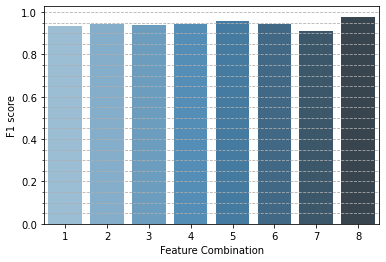

In [19]:
# bar plot of f1 scores

fig = sns.barplot(x=np.arange(1,9), y=f1_scores,palette="Blues_d")
    
plt.xlabel('Feature Combination')
plt.ylabel('F1 score')
plt.title("")
ticks = np.arange(0, 1, 0.05)
fig.set_yticks(ticks, minor=True)
fig.grid(which='both',axis='y',linestyle='dashed')
plt.rc('axes', axisbelow=True)
plt.savefig('saved_figures_2/f1_scores_MLP.png')
#plt.close()

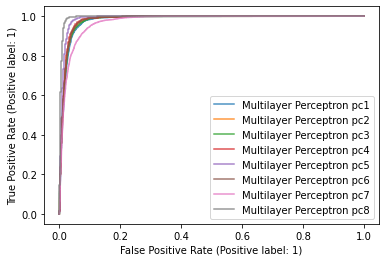

In [26]:
# plot of ROC curves

ax = plt.gca()
n = 0
for i in ROC_curves:
    n += 1
    i.plot(ax=ax, alpha=0.8, label = 'Multilayer Perceptron '+ 'pc'+ str(n))
plt.savefig('saved_figures_2/ROC_curve_feature_combinations_MLP_2.png')   

In [21]:
cv_scores_RF = pd.DataFrame(CV_scores)
cv_scores_RF.to_excel('MLP_CV_scores_training2.xlsx')

In [22]:
f1_scores_RF = pd.DataFrame(f1_scores)
f1_scores_RF.to_excel('MLP_F1_scores2.xlsx')

In [23]:
accuracy_scores_RF = pd.DataFrame(accuracy_scores)
accuracy_scores_RF.to_excel('MLP_accuracy_scores2.xlsx')

In [24]:
precision_scores_RF = pd.DataFrame(precision_scores)
precision_scores_RF.to_excel('MLP_precision_scores2.xlsx')

In [25]:
recall_scores_RF = pd.DataFrame(recall_scores)
recall_scores_RF.to_excel('MLP_recall_scores2.xlsx')

In [26]:
R2_scores_RF = pd.DataFrame(R2_scores)
R2_scores_RF.to_excel('MLP_R2_scores2.xlsx')

In [ ]:
roc_auc_scores = pd.DataFrame(roc_auc_scores)
roc_auc_scores.to_excel('MLP_roc_auc_scores.xlsx')

## Prediction results


In [30]:
validation_y = pd.read_excel('ML_validation_target.xlsx')

df_coor = validation_y[['POINT_X', 'POINT_Y']]

In [32]:
# extracting the values that are probability for rockfall, class 1

df_coor['MLP_prob_p1'] = pred_release_prob_MLP[0][:,1]
df_coor['MLP_prob_p2'] = pred_release_prob_MLP[1][:,1]
df_coor['MLP_prob_p3'] = pred_release_prob_MLP[2][:,1]
df_coor['MLP_prob_p4'] = pred_release_prob_MLP[3][:,1]
df_coor['MLP_prob_p5'] = pred_release_prob_MLP[4][:,1]
df_coor['MLP_prob_p6'] = pred_release_prob_MLP[5][:,1]
df_coor['MLP_prob_p7'] = pred_release_prob_MLP[6][:,1]
df_coor['MLP_prob_p8'] = pred_release_prob_MLP[7][:,1]

<ipython-input-32-361dda0d81ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coor['MLP_prob_p1'] = pred_release_prob_MLP[0][:,1]


In [33]:
df_coor['MLP_prediction_p1'] = pred_release_testing_MLP[0]
df_coor['MLP_prediction_p2'] = pred_release_testing_MLP[1]
df_coor['MLP_prediction_p3'] = pred_release_testing_MLP[2]
df_coor['MLP_prediction_p4'] = pred_release_testing_MLP[3]
df_coor['MLP_prediction_p5'] = pred_release_testing_MLP[4]
df_coor['MLP_prediction_p6'] = pred_release_testing_MLP[5]
df_coor['MLP_prediction_p7'] = pred_release_testing_MLP[6]
df_coor['MLP_prediction_p8'] = pred_release_testing_MLP[7]

In [37]:
df_coor['ReleaseArea'] = validation_y['ReleaseArea'] 

In [38]:
result1 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p1'].iloc[row] == 1:
        result1.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p1'].iloc[row] == 0:
        result1.append('TN')
    elif df_coor['MLP_prediction_p1'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result1.append('FP')
    elif df_coor['MLP_prediction_p1'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result1.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p1'] = result1

In [39]:
result2 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p2'].iloc[row] == 1:
        result2.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p2'].iloc[row] == 0:
        result2.append('TN')
    elif df_coor['MLP_prediction_p2'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result2.append('FP')
    elif df_coor['MLP_prediction_p2'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result2.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p2'] = result2

In [40]:
result3 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p3'].iloc[row] == 1:
        result3.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p3'].iloc[row] == 0:
        result3.append('TN')
    elif df_coor['MLP_prediction_p3'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result3.append('FP')
    elif df_coor['MLP_prediction_p3'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result3.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p3'] = result3

In [41]:
result4 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p4'].iloc[row] == 1:
        result4.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p4'].iloc[row] == 0:
        result4.append('TN')
    elif df_coor['MLP_prediction_p4'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result4.append('FP')
    elif df_coor['MLP_prediction_p4'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result4.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p4'] = result4

In [42]:
result5 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p5'].iloc[row] == 1:
        result5.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p5'].iloc[row] == 0:
        result5.append('TN')
    elif df_coor['MLP_prediction_p5'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result5.append('FP')
    elif df_coor['MLP_prediction_p5'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result5.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p5'] = result5

In [43]:
result6 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p6'].iloc[row] == 1:
        result6.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p6'].iloc[row] == 0:
        result6.append('TN')
    elif df_coor['MLP_prediction_p6'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result6.append('FP')
    elif df_coor['MLP_prediction_p6'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result6.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p6'] = result6

In [44]:
result7 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p7'].iloc[row] == 1:
        result7.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p7'].iloc[row] == 0:
        result7.append('TN')
    elif df_coor['MLP_prediction_p7'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result7.append('FP')
    elif df_coor['MLP_prediction_p7'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result7.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p7'] = result7

In [45]:
result8 = []
for row in range(0,len(df_coor)):
    if df_coor['ReleaseArea'].iloc[row] == 1 and df_coor['MLP_prediction_p8'].iloc[row] == 1:
        result8.append('TP')
    elif df_coor['ReleaseArea'].iloc[row] == 0 and df_coor['MLP_prediction_p8'].iloc[row] == 0:
        result8.append('TN')
    elif df_coor['MLP_prediction_p8'].iloc[row] == 1 and df_coor['ReleaseArea'].iloc[row] == 0:
        result8.append('FP')
    elif df_coor['MLP_prediction_p8'].iloc[row] == 0 and df_coor['ReleaseArea'].iloc[row] == 1:
        result8.append('FN')
    else:
        print('NaN')
        
        
df_coor['result_p8'] = result8

In [46]:
df_coor.to_excel('prediction_results_validation_MLP2.xlsx')